# Clinical Data Analysis

**Standard Imports**

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_curve, balanced_accuracy_score
from sklearn import metrics
import scipy
from collections import Counter

**Import Data**

In [2]:
df_ann = pd.read_csv('data/clinical/Harmonized_Clinical_Dictionary.csv')
df_clin = pd.read_csv('data/clinical/sc3_Training_ClinAnnotations.csv')
df_exp = pd.read_csv('data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv', index_col=False)
df_test = pd.read_csv('data/clinical/sc3_SimmulatedValidation_ClinAnnotations.csv')
df_treatments = pd.read_csv('data/treatments/MMRF_Treatment_Fields.csv')

# Group of features
clinical_features = ["D_Age", "D_ISS"] # "D_Gender", ]
cyto_features = ['CYTO_predicted_feature_0' + str(x) for x in range(1, 10)] + ['CYTO_predicted_feature_' + str(x) for x in range(10, 19)]
labels = ['D_OS', 'D_PFS', 'HR_FLAG']

In [3]:
df_test['Study'].unique()

array(['DFCI', 'M2Gen'], dtype=object)

Get patient data that has RNA-seq profiles

In [8]:
df_clin.columns

Index(['Study', 'Patient', 'D_Age', 'D_Gender', 'D_OS', 'D_OS_FLAG', 'D_PFS',
       'D_PFS_FLAG', 'D_ISS', 'PatientType', 'MA_probeLevelExpFile',
       'MA_probeLevelExpFileSamplId', 'MA_geneLevelExpFile',
       'MA_geneLevelExpFileSamplId', 'RNASeq_transLevelExpFile',
       'RNASeq_transLevelExpFileSamplId', 'RNASeq_geneLevelExpFile',
       'RNASeq_geneLevelExpFileSamplId', 'WES_mutationFileMutect',
       'WES_mutationFileStrelkaIndel', 'WES_mutationFileStrelkaSNV',
       'RNASeq_mutationFileMutect', 'RNASeq_mutationFileStrelkaIndel',
       'RNASeq_mutationFileStrelkaSNV', 'RNASeq_FusionFile',
       'CYTO_predicted_feature_01', 'CYTO_predicted_feature_02',
       'CYTO_predicted_feature_03', 'CYTO_predicted_feature_04',
       'CYTO_predicted_feature_05', 'CYTO_predicted_feature_06',
       'CYTO_predicted_feature_07', 'CYTO_predicted_feature_08',
       'CYTO_predicted_feature_09', 'CYTO_predicted_feature_10',
       'CYTO_predicted_feature_11', 'CYTO_predicted_feature_12',


In [9]:
train_ids = []
exp_ids = df_exp.columns[1:]
for patient_id in df_clin['RNASeq_geneLevelExpFileSamplId']:
    if patient_id in exp_ids:
        train_ids.append(patient_id)
print("Number of patients that have clinical and RNAseq data: {}".format(len(train_ids)))

Number of patients that have clinical and RNAseq data: 583


In [16]:
df_clin['RNASeq_transLevelExpFile'].isna().mean()

0.0

In [27]:
df_test['Study'].unique()

array(['DFCI', 'M2Gen'], dtype=object)

**Feature description**

In [18]:
df_clin.columns

Index(['Study', 'Patient', 'D_Age', 'D_Gender', 'D_OS', 'D_OS_FLAG', 'D_PFS',
       'D_PFS_FLAG', 'D_ISS', 'PatientType', 'MA_probeLevelExpFile',
       'MA_probeLevelExpFileSamplId', 'MA_geneLevelExpFile',
       'MA_geneLevelExpFileSamplId', 'RNASeq_transLevelExpFile',
       'RNASeq_transLevelExpFileSamplId', 'RNASeq_geneLevelExpFile',
       'RNASeq_geneLevelExpFileSamplId', 'WES_mutationFileMutect',
       'WES_mutationFileStrelkaIndel', 'WES_mutationFileStrelkaSNV',
       'RNASeq_mutationFileMutect', 'RNASeq_mutationFileStrelkaIndel',
       'RNASeq_mutationFileStrelkaSNV', 'RNASeq_FusionFile',
       'CYTO_predicted_feature_01', 'CYTO_predicted_feature_02',
       'CYTO_predicted_feature_03', 'CYTO_predicted_feature_04',
       'CYTO_predicted_feature_05', 'CYTO_predicted_feature_06',
       'CYTO_predicted_feature_07', 'CYTO_predicted_feature_08',
       'CYTO_predicted_feature_09', 'CYTO_predicted_feature_10',
       'CYTO_predicted_feature_11', 'CYTO_predicted_feature_12',


In [19]:
feature = 'RNASeq_geneLevelExpFile'
x = df_clin[feature].unique()[0]
print("All the transciptomic data is in the file:{}".format(x))

All the transciptomic data is in the file:MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv


**Summary of clinical features**

- **"Study"**: Study cohort the patient belongs to
- **"Patient"**: Normalized patient ID
- **"D_Age"**: Age at diagnosis (years)
- **"D_Gender"**: Gender of the patient (Male / Female)
- **"D_OS"**: Overall Survival time: number of days from (trial randomization or diagnosis) to (death or last assessment).
- **"D_OS_Flag"**: Is the patient deceased? (Yes / No)
- **"D_PFS"**: Progression-free survival: number of days from (trial randomization or diagnosis) to (disease progression, death, or last assessment
- **"D_PFS_Flag"**: Has the patient developed progressive disease or death since the last assessment date? (Yes/No)
- **"D_ISS"**: Disease stage (from 1 to 3)
- **"HR_FLAG"** (High risk flag) Label (0/1)

**Summary of Gene expression data**
- **RNASeq_transLevelExpFile**: File name of RNAseq transcript level data (matrix)
- **RNASeq_geneLevelExpFileSamplId**: Identifier corresponding to Patient in RNASeq_transLevelExpFile
- **RNASeq_geneLevelExpFile**: File name of RNAseq gene level data (matrix)
- **RNASeq_geneLevelExpFileSamplId**: Identifier corresponding to Patient in RNASeq_geneLevelExpFile

**On RNA-seq counts data normalization**


In recent years RNA-sequencing (RNA-seq) has emerged as a powerful technology for transcriptome profiling. For a given gene, the number of mapped reads is not only dependent on its expression level and gene length, but also the sequencing depth. To normalize these dependencies, RPKM (Reads Per Kilobase of transcript per Million reads mapped) and TPM (Transcripts Per Million) were used to measure gene or transcript expression levels. A common misconception is that RPKM and TPM values are already normalized, and thus should be comparable across samples or RNA-seq projects. However, RPKM and TPM represent the relative abundance of a transcript among a population of sequenced transcripts, and therefore depend on the composition of the RNA population in a sample. Quite often, it is reasonable to assume that total RNA concentration and distributions is very close across compared samples. Nevertheless, the sequenced RNA repertoires may differ significantly under different experimental conditions and/or across sequencing protocols; thus, the proportion of gene expression is not directly comparable in such cases. Researchers from Pfizer illustrate typical scenarios in which RPKM and TPM are misused, unintentionally, and hope to raise scientists’ awareness of this issue when comparing them across samples or different sequencing protocols.

***Description of feature***

In [20]:
feature_name = 'D_OS'
df_ann.loc[(df_ann['names'] == feature_name), :]

,names,category,type,controlled_values,description,MMRF_IA8,GSE15695_UAMS,Hose,UAMS.UK.MyelomaXI,M2GEN,active
27,D_OS,response,Numeric,NaN,Overall Survival time: number of days from (tr...,STAND_ALONE_SURVIVAL.ttcos,NaN,as.numeric(OS) /12 * 365.25,OS_months/12*365.25,NaN,1.0


***description***

In [21]:
df_ann.loc[(df_ann['names'] == feature_name), :]['description'].values[0]

'Overall Survival time: number of days from (trial randomization or diagnosis) to (death or last assessment).'

All patients in the clinical data come from the MMRF study

In [22]:
print("Name of the cohort study : {}".format(df_clin['Study'].unique()[0]))

Name of the cohort study : MMRF


Total number of unique patients

In [23]:
print("There are {} Patients in the cohort study".format(df_clin['Patient'].unique().shape[0]))

There are 583 Patients in the cohort study


All patient are "Newly Diagnosed"

In [24]:
df_clin.loc[:, ['PatientType']]['PatientType'].unique()[0]

'NewlyDiagnosed'

**Distribution of age**

There are 0.0 missing values for the D_age feature


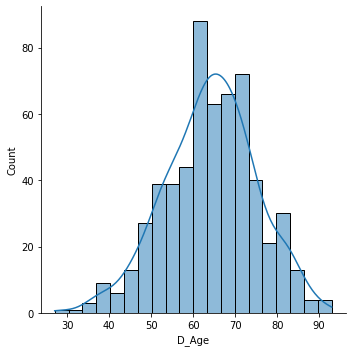

In [1021]:
x = df_clin['D_Age'].isna().astype(int).mean()
print("There are {} missing values for the {} feature".format(x, 'D_age'))
sns.displot(df_clin['D_Age'], kde=True)
plt.show()

plotting D_Age and D_OS features

//anaconda3/envs/owkin/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Spearman correlation SpearmanrResult(correlation=-0.13571131314518975, pvalue=0.0010198965571067756)


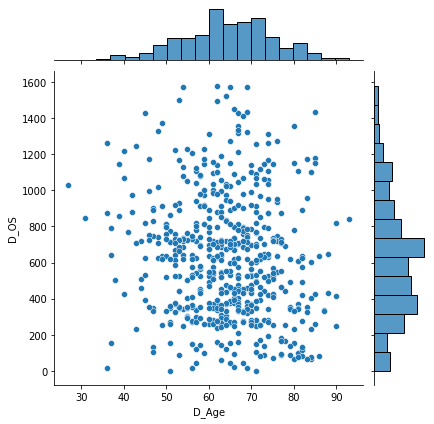

In [1022]:
sns.jointplot(df_clin['D_Age'],  df_clin['D_OS'])
r = scipy.stats.spearmanr(df_clin['D_Age'].values, df_clin['D_OS'].values)
print("Spearman correlation {}".format(r))

binning the age feature

In [1023]:
bins = [0, 35, 50, 60, 70, 80, 200]
labels_bins = [1, 2, 3, 4, 5, 6]
df_clin["D_Age"] = pd.cut(df_clin["D_Age"],
                          bins=bins,
                          labels=labels_bins
                         )

Histogram of "D_Age"

//anaconda3/envs/owkin/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='D_Age', ylabel='count'>

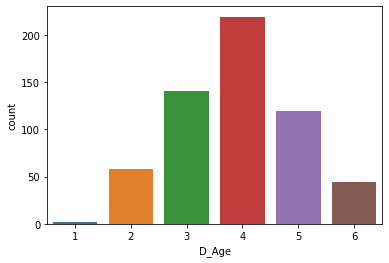

In [1024]:
sns.countplot(df_clin["D_Age"])

**Distribution of gender**

There are 0.0 missing values for the D_Gender feature


<AxesSubplot:xlabel='D_Gender', ylabel='count'>

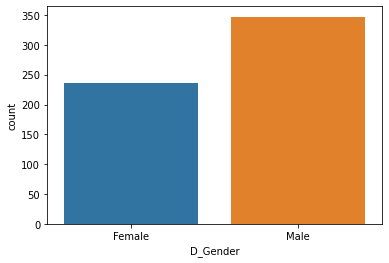

In [1025]:
x = df_clin['D_Gender'].isna().astype(int).mean()
print("There are {} missing values for the {} feature".format(x, 'D_Gender'))

sns.countplot(df_clin['D_Gender'])

Encode gender feature

In [1026]:
replace_dict = {"Male": 0, "Female": 1}

# Encode binary variables
df_clin = df_clin.replace(replace_dict)
df_test = df_test.replace(replace_dict)

**Distribution of ISS**

//anaconda3/envs/owkin/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='D_ISS', ylabel='count'>

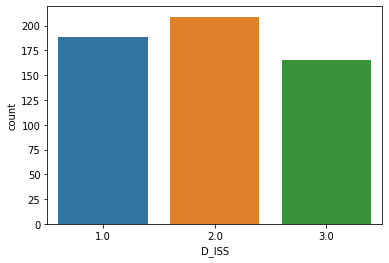

In [1027]:
sns.countplot(df_clin['D_ISS'])

In [1028]:
# Handling missing values
df_clin[['D_ISS']] = df_clin[['D_ISS']].fillna(2)
df_test[['D_ISS']] = df_test[['D_ISS']].fillna(2)

x = df_clin['D_ISS'].isna().astype(int).mean()
print("There are {} missing values for the {} feature".format(x, 'D_ISS'))

There are 0.0 missing values for the D_ISS feature


**Distribution of Overall survival time**

Probability of survival start dropping rapidly above 800 days. OS shoudl a be a good predictor for High Risk patienr deteciton. Indeed, a low OS should be correlated with a positive HR Flag (i.e D_OS < 18 months)

There are 0.0 missing values for the D_OS feature
16.466552315608922 % of patients are deceased


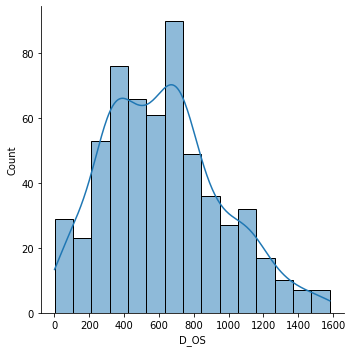

In [1029]:
x = df_clin['D_OS'].isna().astype(int).mean()
print("There are {} missing values for the {} feature".format(x, 'D_OS'))
print("{} % of patients are deceased".format(df_clin['D_OS_FLAG'].mean()*100))

sns.displot(data=df_clin['D_OS'], kde=True)

**Distribution of D_PFS (Progression free survival)**

Comments are similar to what is observerd for the OS feature

There are 0.0 missing values for the D_PFS feature
31.903945111492284 % of patients develloped prgressive disease or are deceased


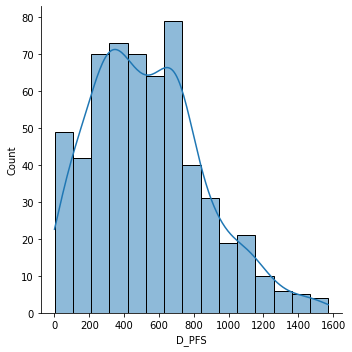

In [1030]:
x = df_clin['D_PFS'].isna().astype(int).mean()
print("There are {} missing values for the {} feature".format(x, 'D_PFS'))
print("{} % of patients develloped prgressive disease or are deceased".format(df_clin['D_PFS_FLAG'].mean()*100))

sns.displot(data=df_clin['D_PFS'], kde=True)

**HR_FLAG (Label)**

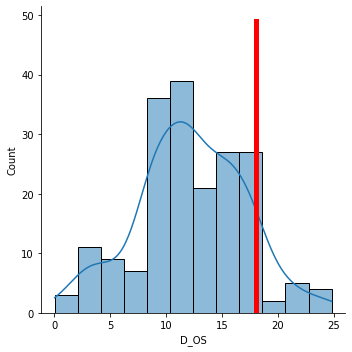

In [1031]:
df_hr = (df_clin[df_clin['HR_FLAG'] == 'CENSORED']['D_OS'] / 30)
sns.displot(data=df_hr, kde=True)

plt.plot([18]*50, range(50), linewidth=5, c='red')

//anaconda3/envs/owkin/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='HR_FLAG', ylabel='count'>

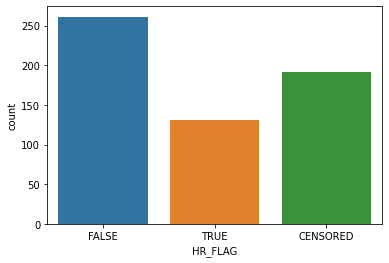

In [1032]:
sns.countplot(df_clin['HR_FLAG'])

Encode label

In [1033]:
replace_dict = {'FALSE': 0, 'TRUE': 1}

df_clin = df_clin[df_clin['HR_FLAG'] != 'CENSORED']
df_clin = df_clin.replace(replace_dict)

**Cytogenetic features**

Handling missing values

In [1052]:
for col in cyto_features:
    rate_na = df_clin[col].isna().mean()
    #rate_na_test = df_test[col].isna().mean()
    if rate_na > 0.3:
    #   df_test = df_test.drop([col], axis=1)
        df_clin = df_clin.drop([col], axis=1)
        cyto_features.remove(col)    

## Correlations

In [1054]:
df_keep = df_clin[clinical_features + labels]

<AxesSubplot:>

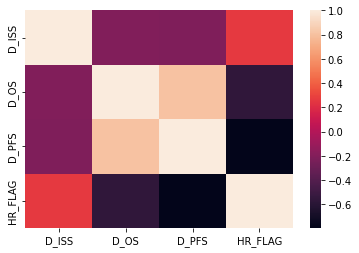

In [1055]:
sns.heatmap(df_keep.corr())

**Interesting correlations**

- D_Age / D_OS 

In [1056]:
#sns.jointplot(data=df_keep,
#             x='D_OS',
#             y='D_Age',
#             kind='kde')

- D_OS / D_PFS (obvious)

<AxesSubplot:xlabel='D_PFS', ylabel='D_OS'>

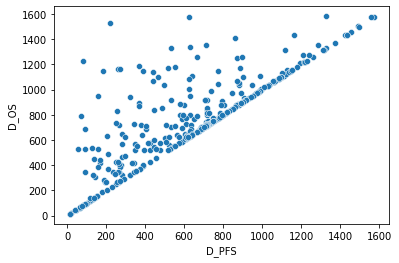

In [1057]:
sns.scatterplot(data=df_keep,
             x='D_PFS',
             y='D_OS')

- D_PFS / HR_FLAG

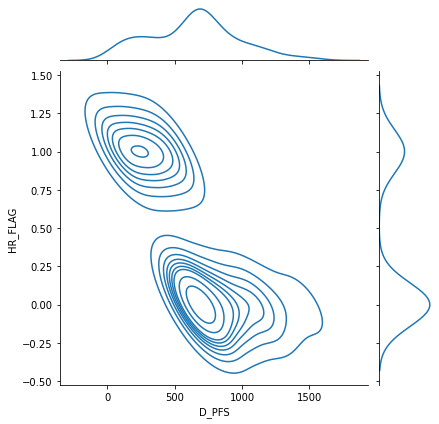

In [1058]:
sns.jointplot(data=df_keep,
             x='D_PFS',
             y='HR_FLAG',
             kind='kde')

## Baseline: Logistic regression

### Metrics

In [1154]:
#def i_auc(y_pred, labels):   

### Training

In [1155]:
y = df_keep['HR_FLAG'].values
FEATURES = clinical_features + cyto_features + ["D_Gender"]
X = df_clin[FEATURES].values

In [1156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, np.mean(y_train), X_test.shape, np.mean(y_test)

((313, 16), 0.33865814696485624, (79, 16), 0.31645569620253167)

In [1157]:
clf = LogisticRegression().fit(X_train, y_train)
#clf = RandomForestClassifier().fit(X_train, y_train)

In [1158]:
y_pred = clf.predict(X_test)

In [1159]:
acc = balanced_accuracy_score(y_pred, y_test)
fpr, tpr, thresh = roc_curve(y_pred, y_test)
auc = metrics.auc(fpr, tpr)

acc, auc

(0.5868298368298368, 0.5868298368298369)

### Feature importance

<AxesSubplot:title={'center':'Feature importances (Train set)'}>

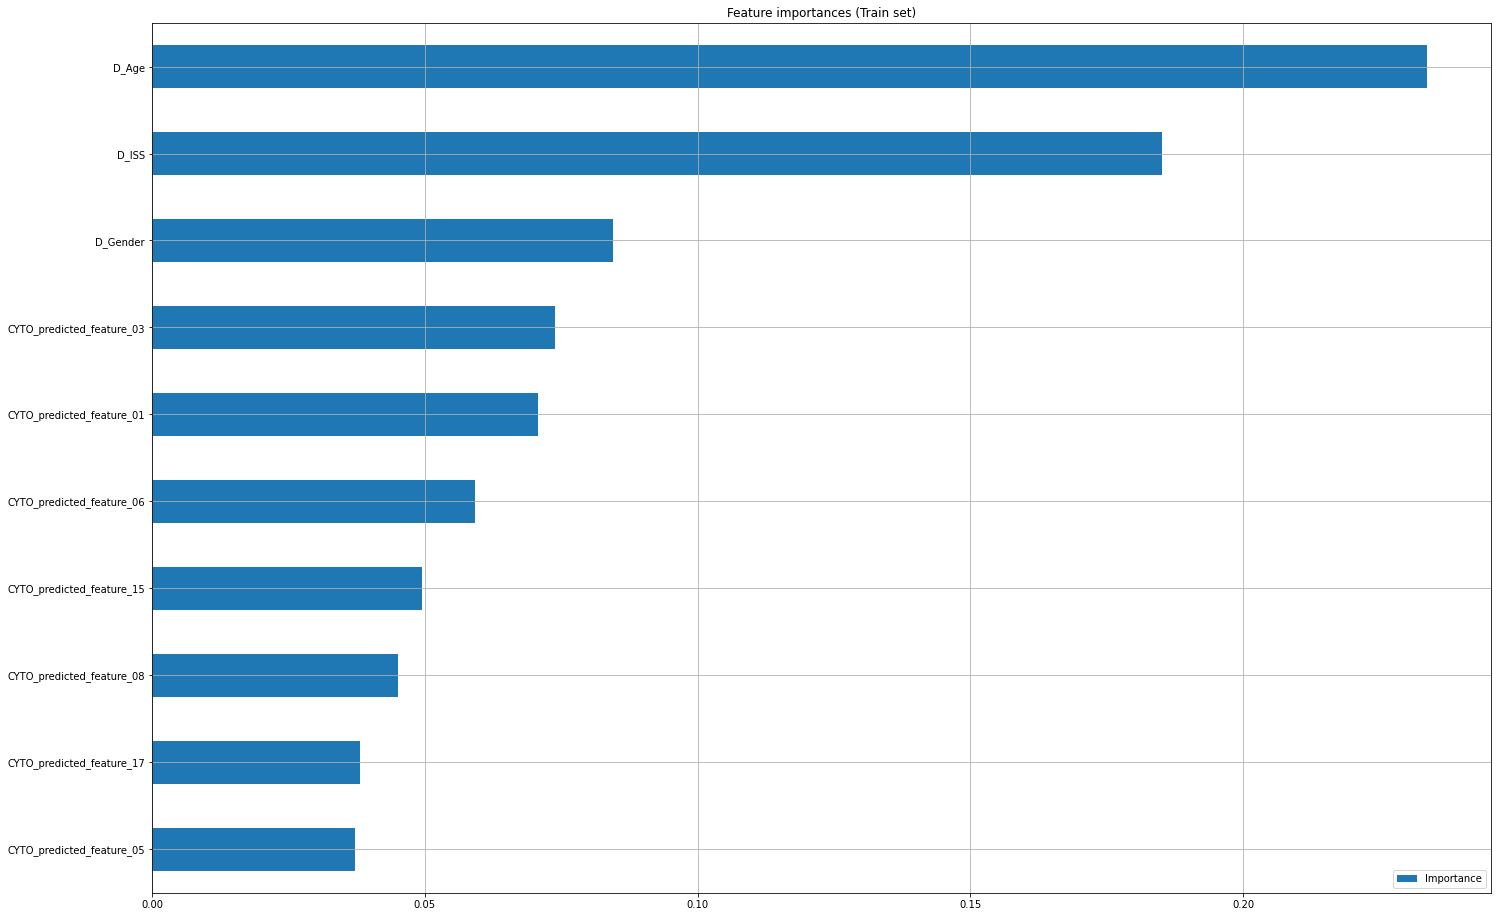

In [1117]:
importance_df = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=list(FEATURES)).sort_values(['Importance'], ascending = True)
importance_df = importance_df.iloc[-10:]  
importance_df.plot(kind='barh', title ="Feature importances (Train set)", grid=True, figsize=(24, 16))

## Analysis of test data

In [966]:
df_test.columns

Index(['Study', 'Patient', 'D_Age', 'D_Gender', 'D_ISS', 'PatientType',
       'MA_probeLevelExpFile', 'MA_probeLevelExpFileSamplId',
       'MA_geneLevelExpFile', 'MA_geneLevelExpFileSamplId',
       'RNASeq_transLevelExpFile', 'RNASeq_transLevelExpFileSamplId',
       'RNASeq_geneLevelExpFile', 'RNASeq_geneLevelExpFileSamplId',
       'WES_mutationFileMutect', 'WES_mutationFileStrelkaIndel',
       'WES_mutationFileStrelkaSNV', 'RNASeq_mutationFileMutect',
       'RNASeq_mutationFileStrelkaIndel', 'RNASeq_mutationFileStrelkaSNV',
       'RNASeq_FusionFile', 'CYTO_predicted_feature_01',
       'CYTO_predicted_feature_02', 'CYTO_predicted_feature_03',
       'CYTO_predicted_feature_04', 'CYTO_predicted_feature_05',
       'CYTO_predicted_feature_06', 'CYTO_predicted_feature_07',
       'CYTO_predicted_feature_08', 'CYTO_predicted_feature_09',
       'CYTO_predicted_feature_10', 'CYTO_predicted_feature_11',
       'CYTO_predicted_feature_12', 'CYTO_predicted_feature_13',
       'CYTO_pr

In [1179]:
for col in df_test.columns:
    print('Feature {} had {} % of missing values'.format(col, df_test[col].isna().mean()*100))

Feature Study had 0.0 % of missing values
Feature Patient had 0.0 % of missing values
Feature D_Age had 15.384615384615385 % of missing values
Feature D_Gender had 0.8547008547008548 % of missing values
Feature D_ISS had 0.0 % of missing values
Feature PatientType had 0.0 % of missing values
Feature MA_probeLevelExpFile had 100.0 % of missing values
Feature MA_probeLevelExpFileSamplId had 100.0 % of missing values
Feature MA_geneLevelExpFile had 100.0 % of missing values
Feature MA_geneLevelExpFileSamplId had 100.0 % of missing values
Feature RNASeq_transLevelExpFile had 0.0 % of missing values
Feature RNASeq_transLevelExpFileSamplId had 0.0 % of missing values
Feature RNASeq_geneLevelExpFile had 0.0 % of missing values
Feature RNASeq_geneLevelExpFileSamplId had 0.0 % of missing values
Feature WES_mutationFileMutect had 82.05128205128204 % of missing values
Feature WES_mutationFileStrelkaIndel had 82.05128205128204 % of missing values
Feature WES_mutationFileStrelkaSNV had 82.051282051

In [1177]:
df_test[col].isna().mean()

0.0